In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Emotions Dataset/train.txt", sep=';', header=None, names=["text", "label"])
val_df   = pd.read_csv("/content/drive/MyDrive/Emotions Dataset/val.txt", sep=';', header=None, names=["text", "label"])
test_df  = pd.read_csv("/content/drive/MyDrive/Emotions Dataset/test.txt", sep=';', header=None, names=["text", "label"])

In [ ]:
train_df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
print("Labels:", train_df['label'].unique())

Labels: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [ ]:
# Get label counts
label_counts = train_df['label'].value_counts()
label_counts

,count
label,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


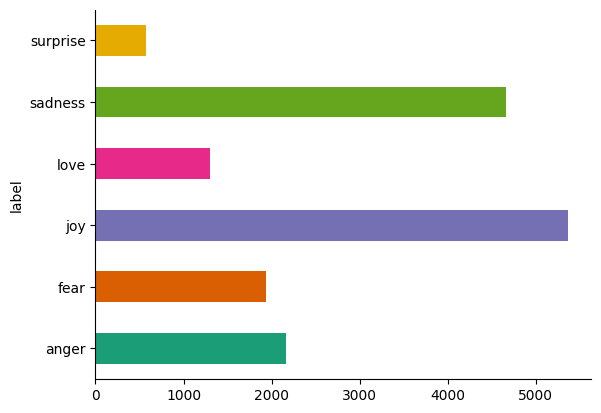

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

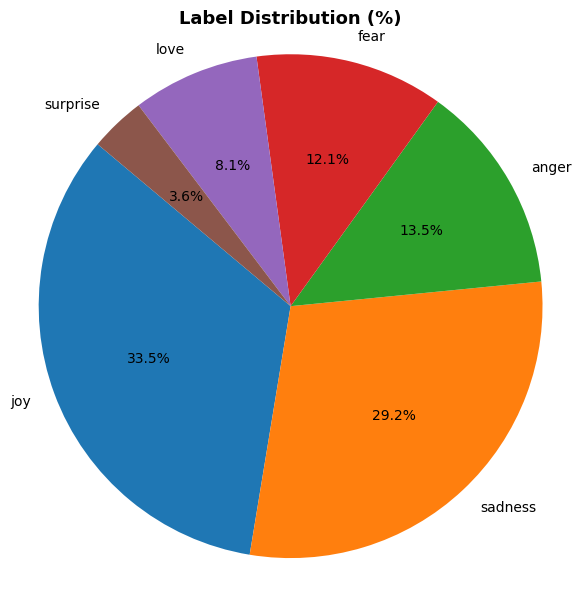

In [ ]:
label_percentage = train_df['label'].value_counts(normalize=True) * 100


plt.figure(figsize=(6, 6))
plt.pie(
    label_percentage,
    labels=label_percentage.index,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 10}
)
plt.title("Label Distribution (%)", fontsize=13, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# Get the word count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
train_df.head()

,text,label,word_count
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,21
2,im grabbing a minute to post i feel greedy wrong,anger,10
3,i am ever feeling nostalgic about the fireplac...,love,18
4,i am feeling grouchy,anger,4


In [ ]:
print("Longest sentence:")
print(train_df.loc[train_df['word_count'].idxmax(), 'text'])

print("\nShortest sentence:")
print(train_df.loc[train_df['word_count'].idxmin(), 'text'])

Longest sentence:
i guess which meant or so i assume no photos no words or no other way to convey what it really feels unless you feels it yourself or khi bi t au th m i bi t th ng ng i b au i rephrase it to a bit more gloomy context unless you are hurt yourself you will never have sympathy for the hurt ones

Shortest sentence:
earth crake


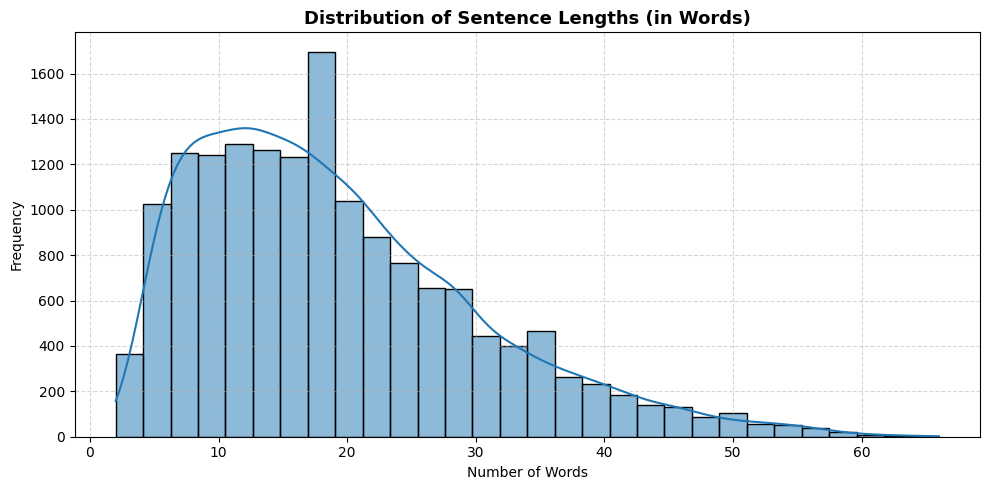

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


plt.figure(figsize=(10, 5))
sns.histplot(train_df["word_count"], bins=30, kde=True, edgecolor="black")
plt.title("Distribution of Sentence Lengths (in Words)", fontweight='bold', fontsize=13)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

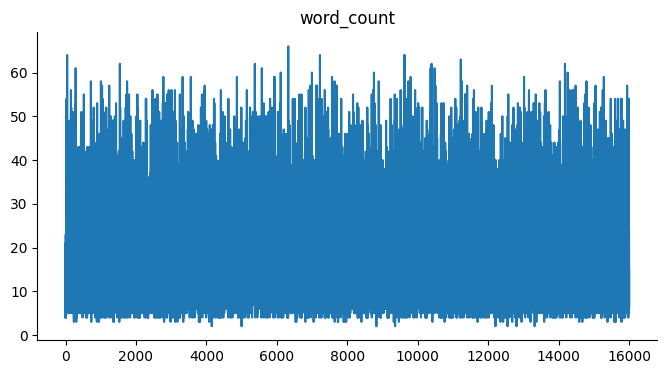

In [ ]:
train_df['word_count'].plot(kind='line', figsize=(8, 4), title='word_count')
plt.gca().spines[['top', 'right']].set_visible(False)

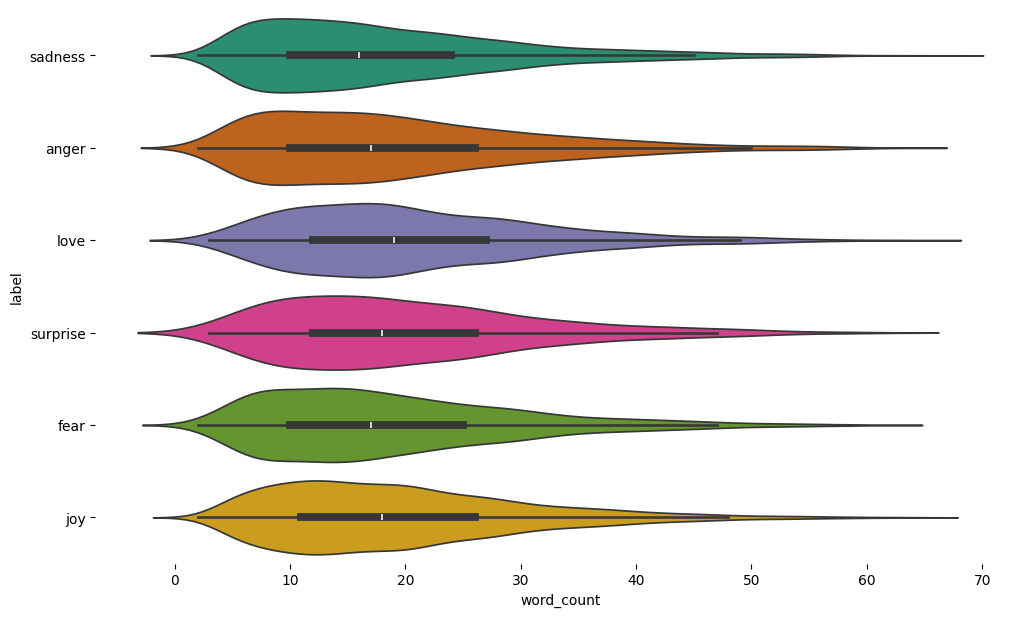

In [ ]:
figsize = (12, 1.2 * len(train_df['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train_df, x='word_count', y='label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

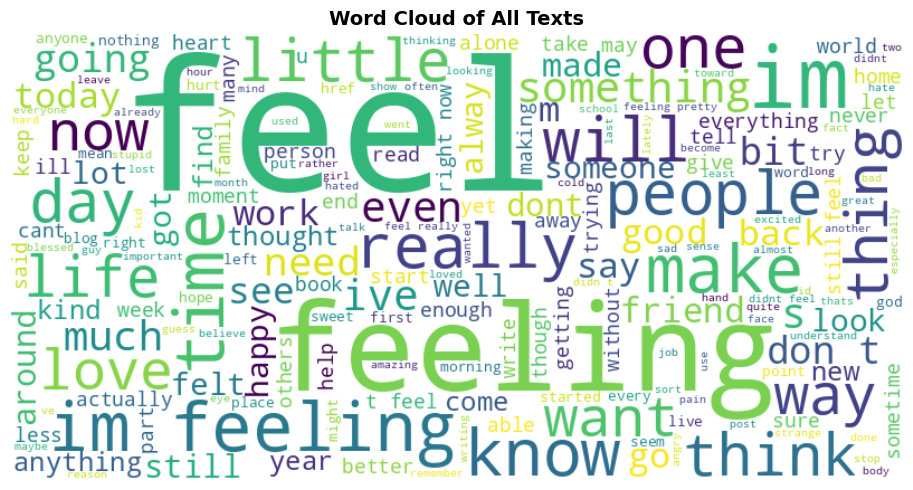

In [ ]:
from wordcloud import WordCloud
from matplotlib.colors import ListedColormap

text_all = " ".join(train_df["text"])


wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text_all)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Texts", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
le = LabelEncoder()
train_df["label_enc"] = le.fit_transform(train_df["label"])
val_df["label_enc"] = le.transform(val_df["label"])
test_df["label_enc"] = le.transform(test_df["label"])

X_train, y_train = train_df["text"], train_df["label"]
X_val, y_val = val_df["text"], val_df["label"]
X_test, y_test = test_df["text"], test_df["label"]

In [ ]:
# Vectorize text
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Predict & evaluate
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.82      0.86       275
        fear       0.89      0.79      0.84       224
         joy       0.84      0.96      0.89       695
        love       0.82      0.59      0.69       159
     sadness       0.90      0.93      0.91       581
    surprise       0.85      0.52      0.64        66

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.81      2000
weighted avg       0.87      0.87      0.86      2000



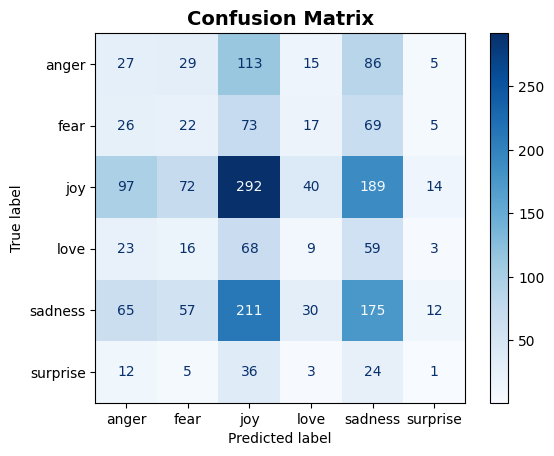

In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
# Uncomment the following line to fit the LabelEncoder
le = LabelEncoder()
train_df["label_enc"] = le.fit_transform(train_df["label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix", fontweight='bold', fontsize=14)
plt.show()

In [ ]:
!pip install Optuna

In [ ]:
# Fine tuning using optuna
import optuna
from sklearn.pipeline import Pipeline

def objective(trial):
    # Define hyperparameters to tune
    # You can suggest different types of parameters, e.g.,
    # 'float', 'int', 'categorical'
    C = trial.suggest_float('C', 1e-3, 10.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'])
    # Add other hyperparameters you want to tune for LogisticRegression

    # Update the pipeline with suggested hyperparameters
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", LogisticRegression(C=C, solver=solver, max_iter=1000))
        # Pass other suggested hyperparameters to LogisticRegression
    ])

    # Train the model
    pipe.fit(X_train, y_train)

    # Evaluate on the validation set
    y_pred = pipe.predict(X_val)

    # Return the metric to minimize or maximize
    # Here, we use the accuracy
    accuracy = pipe.score(X_val, y_val)
    return accuracy

In [ ]:
# Create an Optuna study
study = optuna.create_study(direction='maximize') # 'maximize' for accuracy

# Optimize the study
study.optimize(objective, n_trials=50) # Run for a certain number of trials

# Print the best hyperparameters and best score
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-06-17 18:03:17,029] A new study created in memory with name: no-name-678c4259-6cbc-485c-a42e-127dcf8569ea
[I 2025-06-17 18:03:20,147] Trial 0 finished with value: 0.352 and parameters: {'C': 0.0019144593655015226, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.352.
[I 2025-06-17 18:03:24,218] Trial 1 finished with value: 0.753 and parameters: {'C': 0.3163004857506327, 'solver': 'liblinear'}. Best is trial 1 with value: 0.753.
[I 2025-06-17 18:03:25,883] Trial 2 finished with value: 0.352 and parameters: {'C': 0.0019557547470043925, 'solver': 'newton-cg'}. Best is trial 1 with value: 0.753.
[I 2025-06-17 18:03:41,083] Trial 3 finished with value: 0.886 and parameters: {'C': 2.8668668475917265, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.886.
[I 2025-06-17 18:03:42,349] Trial 4 finished with value: 0.7785 and parameters: {'C': 0.29853449107805013, 'solver': 'saga'}. Best is trial 3 with value: 0.886.
[I 2025-06-17 18:03:44,076] Trial 5 finished with value: 0.6805 and par

Best hyperparameters: {'C': 9.785143526938423, 'solver': 'liblinear'}
Best accuracy: 0.897


In [ ]:
# Use the best hyperparameters to build the final model
best_params = study.best_params

final_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000, **best_params))
])

# Train the model on the training data
final_pipe.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred_test = final_pipe.predict(X_test)

# Print the classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

Classification Report on Test Set:
              precision    recall  f1-score   support

       anger       0.89      0.87      0.88       275
        fear       0.86      0.83      0.84       224
         joy       0.90      0.93      0.91       695
        love       0.81      0.75      0.78       159
     sadness       0.92      0.93      0.92       581
    surprise       0.72      0.59      0.65        66

    accuracy                           0.89      2000
   macro avg       0.85      0.82      0.83      2000
weighted avg       0.88      0.89      0.88      2000



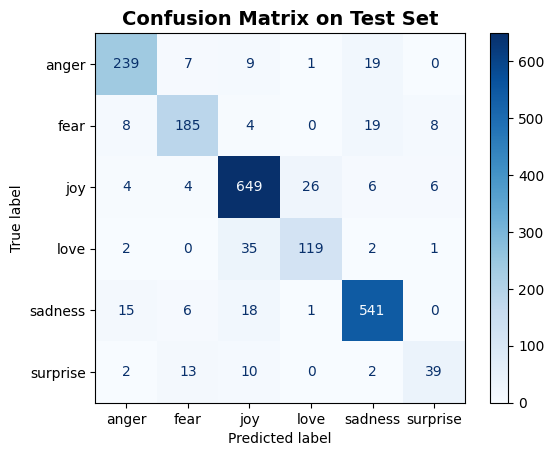

In [ ]:
# Plot the confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=le.classes_)
disp_test.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix on Test Set", fontweight='bold', fontsize=14)
plt.show()

The accuracy increased from 86% to 89% which is a good one. But I would like to try transformers as well as they are well trained on very large datasets.

In [ ]:
le = LabelEncoder()
train_df["label_enc"] = le.fit_transform(train_df["label"])
val_df["label_enc"] = le.transform(val_df["label"])
test_df["label_enc"] = le.transform(test_df["label"])

X_train, y_train = train_df["text"], train_df["label_enc"]
X_val, y_val = val_df["text"], val_df["label_enc"]
X_test, y_test = test_df["text"], test_df["label_enc"]

In [ ]:
from datasets import load_dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(le.classes_))

# Tokenize - Convert Pandas Series to lists
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)

# Create torch Dataset
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset = EmotionDataset(val_encodings, y_val)

# Trainer
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    # Changed from evaluation_strategy to eval_strategy
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    from sklearn.metrics import accuracy_score, f1_score
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tastynhealthycooking (tastynhealthycooking-feynn-lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.264300,0.205219,0.925500,0.925705
2,0.127100,0.171090,0.929500,0.928652
3,0.114700,0.153773,0.939500,0.939352


TrainOutput(global_step=3000, training_loss=0.24525364061196644, metrics={'train_runtime': 931.4681, 'train_samples_per_second': 51.532, 'train_steps_per_second': 3.221, 'total_flos': 2170744164864000.0, 'train_loss': 0.24525364061196644, 'epoch': 3.0})

The accuracy with RoBERTa is 94% which is really good.

In [ ]:
import joblib
from google.colab import files
joblib.dump(le, 'label_encoder.pkl')
files.download('label_encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Saving everything
import joblib
model.save_pretrained('./roberta_emotion_model')
tokenizer.save_pretrained('./roberta_emotion_model')
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(model, 'roberta_emotion_classifier.pkl')
joblib.dump(clf, 'tfidf_logreg_emotion.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [ ]:
!ls -lh

total 888M
drwx------ 5 root root 4.0K Jun 17 17:32 drive
-rw-r--r-- 1 root root  522 Jun 17 18:54 label_encoder.pkl
drwxr-xr-x 2 root root 4.0K Jun 17 17:36 logs
drwxr-xr-x 5 root root 4.0K Jun 17 17:51 results
-rw-r--r-- 1 root root 476M Jun 17 18:54 roberta_emotion_classifier.pkl
drwxr-xr-x 2 root root 4.0K Jun 17 18:12 roberta_emotion_model
-rw-r--r-- 1 root root 411M Jun 17 18:56 roberta_emotion_model.zip
drwxr-xr-x 1 root root 4.0K Jun 16 13:32 sample_data
-rw-r--r-- 1 root root 236K Jun 17 18:54 tfidf_logreg_emotion.pkl
-rw-r--r-- 1 root root 180K Jun 17 18:54 tfidf_vectorizer.pkl
-rw-r--r-- 1 root root 1.5M Jun 17 18:48 tokenizer.pkl
drwxr-xr-x 3 root root 4.0K Jun 17 17:37 wandb


In [ ]:
from google.colab import files
files.download('label_encoder.pkl')
files.download('roberta_emotion_classifier.pkl')
files.download('tfidf_logreg_emotion.pkl')
files.download('tfidf_vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r roberta_emotion_model.zip roberta_emotion_model
files.download('roberta_emotion_model.zip')

  adding: roberta_emotion_model/ (stored 0%)
  adding: roberta_emotion_model/config.json (deflated 55%)
  adding: roberta_emotion_model/tokenizer_config.json (deflated 75%)
  adding: roberta_emotion_model/special_tokens_map.json (deflated 52%)
  adding: roberta_emotion_model/merges.txt (deflated 53%)
  adding: roberta_emotion_model/tokenizer.json (deflated 82%)
  adding: roberta_emotion_model/vocab.json (deflated 59%)
  adding: roberta_emotion_model/model.safetensors (deflated 14%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # Save model and tokenizer
# from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
# import torch # Ensure torch is imported if needed for model saving, although save_pretrained usually handles this

# model.save_pretrained('./roberta_emotion_model')
# tokenizer.save_pretrained('./roberta_emotion_model')

# # Verify the contents of the directory before proceeding
# !ls -R ./roberta_emotion_model

# # Save label encoder for inference
# import joblib
# joblib.dump(le, 'label_encoder.pkl')

# # Save model & vectorizer
# joblib.dump(clf, 'tfidf_logreg_emotion.pkl')
# joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# # Now, attempt to download the files
# from google.colab import files

# files.download('tfidf_logreg_emotion.pkl')
# files.download('tfidf_vectorizer.pkl')
# files.download('label_encoder.pkl')
# files.download('roberta_emotion_model/config.json')
# # This line will now only execute if the file is verified to exist
# files.download('roberta_emotion_model/pytorch_model.bin')
# files.download('roberta_emotion_model/tokenizer.json')